<a href="https://colab.research.google.com/github/OmegaJN/KNX/blob/master/Option1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install QuantLib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Расчет америанского опциона

import QuantLib as ql
from QuantLib.QuantLib import Years
import math
import matplotlib as plt
import pandas as pd

calendar = ql.Russia()
bussiness_convention = ql.ModifiedFollowing
settlement_days = 0
day_count = ql.Actual365Fixed()

interest_rate = 0.075
calc_date = ql.Date.todaysDate() # current date
yield_curve = ql.FlatForward(calc_date, 
                             interest_rate,
                             day_count,
                             ql.Compounded,
                             ql.Continuous)

ql.Settings.instance().evaluationDate = calc_date
option_maturity_date = ql.Date(15,6,2023) # Expire day
strike = 97500
spot = 98030 # futures price
volatility = 31/100.
flavor = ql.Option.Call

discount = yield_curve.discount(option_maturity_date)
strikepayoff = ql.PlainVanillaPayoff(flavor, strike)
T = yield_curve.dayCounter().yearFraction(calc_date, 
                                          option_maturity_date)
stddev = volatility*math.sqrt(T)

black = ql.BlackCalculator(strikepayoff, 
                           spot, 
                           stddev, 
                           discount)

print('\n','==== Price option ====')
print ("Option Price", black.value() )

print('\n','==== Greeks Call option ====')
print ("Delta", black.delta(spot) )
print ("Gamma", black.gamma(spot) )
print ("Theta", black.theta(spot, T)/100 )
print ("Vega", black.vega(T)/100 )
print ("Rho", black.rho( T) )

flavor1 = ql.Option.Put

discount1 = yield_curve.discount(option_maturity_date)
strikepayoff1 = ql.PlainVanillaPayoff(flavor1, strike)
T1 = yield_curve.dayCounter().yearFraction(calc_date, 
                                          option_maturity_date)
stddev = volatility*math.sqrt(T1)

black1 = ql.BlackCalculator(strikepayoff1, 
                           spot, 
                           stddev, 
                           discount1)
print('\n','==== Greeks Put option ====')
print ("Delta", black1.delta(spot) )
print ("Gamma", black1.gamma(spot) )
print ("Theta", black1.theta(spot, T)/100 )
print ("Vega", black1.vega(T)/100 )
print ("Rho", black1.rho( T) )


def calc_greeks(option_type, S, K, r, sigma, T):
    payoff = ql.PlainVanillaPayoff(ql.Option.Call if option_type=='call' else ql.Option.Put, K)
    exercise = ql.EuropeanExercise(ql.Date().todaysDate() + ql.Period(int(T*12), ql.Months))
    underlying = ql.QuoteHandle(ql.SimpleQuote(S))
    risk_free_rate = ql.YieldTermStructureHandle(ql.FlatForward(0, ql.TARGET(), r, ql.Actual365Fixed()))
    volatility = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(0, ql.TARGET(), sigma, ql.Actual365Fixed()))
    
    process = ql.BlackScholesProcess(underlying, risk_free_rate, volatility)
    option = ql.VanillaOption(payoff, exercise)
    option.setPricingEngine(ql.AnalyticEuropeanEngine(process))
    
    delta = option.delta()
    gamma = option.gamma()
    theta = option.thetaPerDay()
    rho = option.rho()
    
    return (delta, gamma, theta, rho)

print('\n','==== Greeks Call option ====')
option_type = 'call'
delta, gamma, theta, rho = calc_greeks(option_type, spot, strike, interest_rate, volatility, T)
print("Delta:", delta)
print("Gamma:", gamma)
print("Theta:", theta)
print("Rho:", rho)

print('\n','==== Greeks Put option ====')
option_type = 'put'
delta, gamma, theta, rho = calc_greeks(option_type, spot, strike, interest_rate, volatility, T)
print("Delta:", delta)
print("Gamma:", gamma)
print("Theta:", theta)
print("Rho:", rho)

print('\n Today:', ql.Date.todaysDate(),'\n \n Time to maturity:',int(T*365), 'Days \n')

# Create DataFrame
df = pd.DataFrame(columns=['Asset price', 'Strike', 'Option price', 'Volatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho'])

# Loop over strike prices

for strike in range(75000, 125000, 2500):
    option = ql.VanillaOption(ql.PlainVanillaPayoff(ql.Option.Call, strike), ql.AmericanExercise(T)) 
    process = ql.BlackScholesProcess(ql.QuoteHandle(ql.SimpleQuote(spot)), ql.YieldTermStructureHandle(ql.FlatForward(T, interest_rate, ql.Actual365Fixed())), ql.BlackVolTermStructureHandle(ql.BlackConstantVol(T, ql.NullCalendar(), volatility, ql.Actual365Fixed()))) 
    engine = ql.BaroneAdesiWhaleyApproximationEngine(process) 
    option.setPricingEngine(engine)

    delta = option.delta()
    gamma = option.gamma()
    theta = option.thetaPerDay()
    vega = option.vega()/100
    rho = option.rho()/100

    # Append values to DataFrame
    df = df.append({
        'Asset price': spot, 
        'Strike': strike, 
        'Option price': option.NPV(), 
        'Volatility': volatility, 
        'Delta': delta, 
        'Gamma': gamma, 
        'Theta': theta, 
        'Vega': vega,
        'Rho': rho}, ignore_index=True)

print(df)


 ==== Price option ====
Option Price 5184.004041744765

 ==== Greeks Call option ====
Delta 0.5355925708120463
Gamma 3.12790871938501e-05
Theta -140.61580368701493
Vega 158.28238837943215
Rho 8037.9408543767895

 ==== Greeks Put option ====
Delta -0.45197864765407253
Gamma 3.12790871938501e-05
Theta -141.00118174212474
Vega 158.28238837943215
Rho -8317.861928164817

 ==== Greeks Call option ====
Delta: 0.581232439528507
Gamma: 3.144423650020245e-05
Theta: -50.28939646817331
Rho: 8548.029249157335

 ==== Greeks Put option ====
Delta: -0.4187675604714932
Gamma: 3.144423650020245e-05
Theta: -30.50469687055194
Rho: -7543.526423574602

 Today: April 14th, 2023 
 
 Time to maturity: 62 Days 



TypeError: ignored

In [ ]:
# Расчет америанского опциона

import QuantLib as ql
from QuantLib.QuantLib import Years
import math
import matplotlib as plt
import pandas as pd

calendar = ql.Russia()
bussiness_convention = ql.ModifiedFollowing
settlement_days = 0
day_count = ql.Actual365Fixed()
strike_prices = range(75000, 125000, 2500)

interest_rate = 0.075
calc_date = ql.Date.todaysDate() # current date
yield_curve = ql.FlatForward(calc_date, 
                             interest_rate,
                             day_count,
                             ql.Compounded,
                             ql.Continuous)

ql.Settings.instance().evaluationDate = calc_date
option_maturity_date = ql.Date(15,6,2023) # Expire day
strike = 97500
spot = 98030 # futures price
volatility = 31/100.
flavor = ql.Option.Call

discount = yield_curve.discount(option_maturity_date)
strikepayoff = ql.PlainVanillaPayoff(flavor, strike)
T = yield_curve.dayCounter().yearFraction(calc_date, 
                                          option_maturity_date)
stddev = volatility*math.sqrt(T)

black = ql.BlackCalculator(strikepayoff, 
                           spot, 
                           stddev, 
                           discount)

print('\n','==== Price option Call ====')
print ("Option Price", black.value() )

print('\n','==== Greeks Call option ====')
print ("Delta", black.delta(spot) )
print ("Gamma", black.gamma(spot) )
print ("Theta", black.theta(spot, T)/100 )
print ("Vega", black.vega(T)/100 )
print ("Rho", black.rho( T) )

flavor1 = ql.Option.Put

discount1 = yield_curve.discount(option_maturity_date)
strikepayoff1 = ql.PlainVanillaPayoff(flavor1, strike)
T1 = yield_curve.dayCounter().yearFraction(calc_date, 
                                          option_maturity_date)
stddev = volatility*math.sqrt(T1)

black1 = ql.BlackCalculator(strikepayoff1, 
                           spot, 
                           stddev, 
                           discount1)

print('\n','==== Price option Put ====')
print ("Option Price", black1.value() )

print('\n','==== Greeks Put option ====')
print ("Delta", black1.delta(spot) )
print ("Gamma", black1.gamma(spot) )
print ("Theta", black1.thetaPerDay(spot, T) )
print ("Vega", black1.vega(T)/100 )
print ("Rho", black1.rho( T) )


print('\n Today:', ql.Date.todaysDate(),'\n \n Time to maturity:',int(T*365), 'Days \n')

# Create DataFrame
df = pd.DataFrame(columns=['Asset price', 'Strike', 'Option price', 'Volatility', 'Delta', 'Gamma', 'Theta', 'Vega', 'Rho'])


# Set up pricing environment
calendar = ql.Russia()
settlement_days = 0
day_count = ql.Actual365Fixed()
yield_ts = ql.FlatForward(ql.Date.todaysDate(), 0.075, day_count)
vol_ts = ql.BlackConstantVol(ql.Date.todaysDate(), calendar, 0.31, day_count)

# Set up option pricing engine
engine = ql.BaroneAdesiWhaleyApproximationEngine(ql.BlackScholesProcess(
    ql.QuoteHandle(ql.SimpleQuote(spot)), 
    ql.YieldTermStructureHandle(yield_ts), 
    ql.BlackVolTermStructureHandle(vol_ts)))

# Loop over strike prices
results = []
for strike in strike_prices:
    option = ql.VanillaOption(
        ql.PlainVanillaPayoff(ql.Option.Call, strike), 
        ql.AmericanExercise(calc_date, option_maturity_date))
    option.setPricingEngine(engine)

    delta = option.delta()
    gamma = option.gamma()
    theta = option.thetaPerDay()
    vega = option.vega()/100
    rho = option.rho()/100

    # Append values to DataFrame
    df = pd.concat([df, pd.DataFrame([[spot, strike, option.NPV(), volatility, delta, gamma, theta, vega, rho]], 
                                      columns=['Asset price', 'Strike', 'Option price', 'Volatility', 'Delta', 'Gamma', 
                                               'Theta', 'Vega', 'Rho'])], ignore_index=True)
print(df)


 ==== Price option Call ====
Option Price 5184.004041744765

 ==== Greeks Call option ====
Delta 0.5355925708120463
Gamma 3.12790871938501e-05
Theta -140.61580368701493
Vega 158.28238837943215
Rho 8037.9408543767895

 ==== Price option Put ====
Option Price 4660.591295957729

 ==== Greeks Put option ====
Delta -0.45197864765407253
Gamma 3.12790871938501e-05
Theta -38.63046075126705
Vega 158.28238837943215
Rho -8317.861928164817

 Today: April 14th, 2023 
 
 Time to maturity: 62 Days 

   Asset price  Strike  Option price  Volatility     Delta     Gamma  \
0        98030   75000  24033.192644        0.31  0.988074  0.000002   
1        98030   77500  21621.360777        0.31  0.977405  0.000004   
2        98030   80000  19252.801978        0.31  0.960318  0.000007   
3        98030   82500  16948.729503        0.31  0.934929  0.000010   
4        98030   85000  14734.242541        0.31  0.899707  0.000014   
5        98030   87500  12636.445257        0.31  0.853830  0.000018   
6    

In [ ]:
# Графики

import matplotlib.pyplot as plt

# График цены опциона (Call и Put)
plt.plot(df['Strike'], df['Option price'], label='Call')
plt.plot(df['Strike'], df['Option price'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Option price')
plt.title('Option price vs Strike')
plt.legend()
plt.show()

# График дельты (Call и Put)
plt.plot(df['Strike'], df['Delta'], label='Call')
plt.plot(df['Strike'], df['Delta'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Delta')
plt.title('Delta vs Strike')
plt.legend()
plt.show()

# График гаммы (Call и Put)
plt.plot(df['Strike'], df['Gamma'], label='Call')
plt.plot(df['Strike'], df['Gamma'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Gamma')
plt.title('Gamma vs Strike')
plt.legend()
plt.show()

# График теты (Call и Put)
plt.plot(df['Strike'], df['Theta'], label='Call')
plt.plot(df['Strike'], df['Theta'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Theta')
plt.title('Theta vs Strike')
plt.legend()
plt.show()

# График веги (Call и Put)
plt.plot(df['Strike'], df['Vega'], label='Call')
plt.plot(df['Strike'], df['Vega'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Vega')
plt.title('Vega vs Strike')
plt.legend()
plt.show()

# График ро (Call и Put)
plt.plot(df['Strike'], df['Rho'], label='Call')
plt.plot(df['Strike'], df['Rho'], label='Put' )
plt.xlabel('Strike')
plt.ylabel('Rho')
plt.title('Rho vs Strike')
plt.legend()
plt.show()

In [ ]:

# Расчет америанского опциона

import QuantLib as ql
import math
import pandas as pd
import numpy as np
from numpy import exp

calendar = ql.Russia()
bussiness_convention = ql.ModifiedFollowing
settlement_days = 0
day_count = ql.Actual365Fixed()
strike_prices = range(75000, 125000, 2500)

interest_rate = 0.075
calc_date = ql.Date.todaysDate() # current date
yield_curve = ql.FlatForward(calc_date, 
                             interest_rate,
                             day_count,
                             ql.Compounded,
                             ql.Continuous)

ql.Settings.instance().evaluationDate = calc_date
option_maturity_date = ql.Date(15,6,2023) # Expire day
spot = 98030 # futures price
volatility = 31/100.
T = yield_curve.dayCounter().yearFraction(calc_date, 
                                          option_maturity_date)
stddev = volatility*math.sqrt(T)

print('\n','==== Price option Call ====')
strike = 97500
flavor = ql.Option.Call
discount = yield_curve.discount(option_maturity_date)
strikepayoff = ql.PlainVanillaPayoff(flavor, strike)
black = ql.BlackCalculator(strikepayoff, 
                           spot, 
                           stddev, 
                           discount)
print ("Option Price", black.value() )

print('\n','==== Greeks Call option ====')
print ("Delta", black.delta(spot) )
print ("Gamma", black.gamma(spot) )
print ("Theta", black.theta(spot, T)/100 )
print ("Vega", black.vega(T)/100 )
print ("Rho", black.rho( T) )

print('\n','==== Price option Put ====')
flavor = ql.Option.Put
strikepayoff = ql.PlainVanillaPayoff(flavor, strike)
black1 = ql.BlackCalculator(strikepayoff, 
                           spot, 
                           stddev, 
                           discount)
print ("Option Price", black1.value() )

print('\n','==== Greeks Put option ====')
print ("Delta", black1.delta(spot) )
print ("Gamma", black1.gamma(spot) )
print ("Theta", black1.theta(spot, T)/100 )
print ("Vega", black1.vega(T)/100 )
print ("Rho", black1.rho( T) )

print('\n Today:', ql.Date.todaysDate(),'\n \n Time to maturity:',int(T*365), 'Days \n')

# Create DataFrame
df = pd.DataFrame(columns=['Asset price', 'Strike', 'Option price (Call)', 'Delta (Call)', 'Gamma (Call)', 'Theta (Call)',
                           'Vega (Call)', 'Rho (Call)', 'Option price (Put)', 'Delta (Put)', 'Gamma (Put)', 'Theta (Put)',
                           'Vega (Put)', 'Rho (Put)'])

# Set up pricing environment
calendar = ql.Russia()
settlement_days = 0
day_count = ql.Actual365Fixed()
yield_ts = ql.FlatForward(ql.Date.todaysDate(), 0.075, day_count)
vol_ts = ql.BlackConstantVol(ql.Date.todaysDate(), calendar, 0.31, day_count)

# Set up option pricing engine
engine = ql.BaroneAdesiWhaleyApproximationEngine(ql.BlackScholesProcess(
    ql.QuoteHandle(ql.SimpleQuote(spot)), 
    ql.YieldTermStructureHandle(yield_ts), 
    ql.BlackVolTermStructureHandle(vol_ts)))

# Loop over strike prices
results = []
for strike in strike_prices:
    option_call = ql.VanillaOption(
        ql.PlainVanillaPayoff(ql.Option.Call, strike), 
        ql.AmericanExercise(calc_date, option_maturity_date))
    option_call.setPricingEngine(engine)

    delta_call = option_call.delta()
    gamma_call = option_call.gamma()
    theta_call = option_call.thetaPerDay()/100
    vega_call = option_call.vega()/100
    rho_call = option_call.rho()/100

    delta_put = delta_call-1
    gamma_put = gamma_call
    theta_put = theta_call-interest_rate*strike*exp(-interest_rate*T)*stddev*(np.log(spot/strike)+(interest_rate-volatility**2/2)/(volatility*np.sqrt(T)))
    vega_put = vega_call
    rho_put = 1# option_put.rho()/100

    # Append values to DataFrame
    df = pd.concat([df, pd.DataFrame([[spot, strike, black.value(), delta_call, delta_put, gamma_call, gamma_put, theta_call, theta_put, vega_call,
                                       rho_call, black1.value(), delta_put, theta_put, vega_put, rho_put]], 
                                      columns=['Asset price', 'Strike', 'Option price (Call)', 'Delta (Call)', 'Delta (Put)',
                                               'Gamma (Call)', 'Gamma (Put)', 'Theta (Call)', 'Theta (Put)', 'Vega (Call)', 'Rho (Call)',
                                               'Option price (Put)', 'Delta (Put)', 'Theta (Put)',
                                               'Vega (Put)', 'Rho (Put)'])], ignore_index=True)

print(df)



 ==== Price option Call ====
Option Price 5184.004041744765

 ==== Greeks Call option ====
Delta 0.5355925708120463
Gamma 3.12790871938501e-05
Theta -140.61580368701493
Vega 158.28238837943215
Rho 8037.9408543767895

 ==== Price option Put ====
Option Price 4660.591295957729

 ==== Greeks Put option ====
Delta -0.45197864765407253
Gamma 3.12790871938501e-05
Theta -141.00118174212474
Vega 158.28238837943215
Rho -8317.861928164817

 Today: April 14th, 2023 
 
 Time to maturity: 62 Days 



InvalidIndexError: ignored

In [ ]:
# Расчет америанского опциона

import QuantLib as ql
from QuantLib.QuantLib import Years
import math
import matplotlib as plt
import pandas as pd

calendar = ql.Russia()
bussiness_convention = ql.ModifiedFollowing
settlement_days = 0
day_count = ql.Actual365Fixed()
strike_prices = range(75000, 125000, 2500)
interest_rate = 0.075
strike = 97500
spot = 98030 # futures price
volatility = 31/100.

# Create DataFrame
df = pd.DataFrame(columns=['Asset price', 'Strike', 'Option price (Call)', 'Option price (Put)', 'Volatility', 'Delta (Call)', 'Delta (Put)', 'Gamma (Call)','Gamma (Put)', 'Theta (Call)', 'Theta (Put)', 'Vega (Call)', 'Vega (Put)', 'Rho (Call)', 'Rho (Put)'])

# Loop over strike prices
results = []
for strike in strike_prices:
  calc_date = ql.Date.todaysDate() # current date
  yield_curve = ql.FlatForward(calc_date, 
                              interest_rate,
                              day_count,
                              ql.Compounded,
                              ql.Continuous)

  ql.Settings.instance().evaluationDate = calc_date
  option_maturity_date = ql.Date(15,6,2023) # Expire day

  # Call

  flavor = ql.Option.Call
  discount = yield_curve.discount(option_maturity_date)
  strikepayoff = ql.PlainVanillaPayoff(flavor, strike)
  T = yield_curve.dayCounter().yearFraction(calc_date, 
                                            option_maturity_date)
  stddev = volatility*math.sqrt(T)

  black = ql.BlackCalculator(strikepayoff, 
                            spot, 
                            stddev, 
                            discount)
  option_price_call = black.value()
  delta = black.delta(spot)
  gamma = black.gamma(spot)
  theta = black.theta(spot, T)/100
  vega = black.vega(T)/100
  rho = black.rho(T)

  # Put

  flavor1 = ql.Option.Put
  discount1 = yield_curve.discount(option_maturity_date)
  strikepayoff1 = ql.PlainVanillaPayoff(flavor1, strike)
  T1 = yield_curve.dayCounter().yearFraction(calc_date, 
                                            option_maturity_date)
  stddev = volatility*math.sqrt(T1)


  black1 = ql.BlackCalculator(strikepayoff1, 
                            spot, 
                            stddev, 
                            discount1)

  option_price_put = black1.value()
  delta_put = black1.delta(spot)
  gamma_put = black1.gamma(spot)
  theta_put = black1.theta(spot, T)/100
  vega_put = black1.vega(T)/100
  rho_put = black1.rho(T)

  # Append values to DataFrame
  df = pd.concat([df, pd.DataFrame([[spot, strike,option_price_call, option_price_put, volatility, delta, delta_put, gamma, gamma_put, theta, theta_put, vega, vega_put, rho, rho_put]], 
                                      columns=['Asset price', 'Strike', 'Option price (Call)', 'Option price (Put)', 'Volatility', 'Delta (Call)', 'Delta (Put)', 'Gamma (Call)','Gamma (Put)', 
                                                'Theta (Call)', 'Theta (Put)', 'Vega (Call)', 'Vega (Put)', 'Rho (Call)', 'Rho (Put)'])], ignore_index=True)


print(df)


In [ ]:
# Графики

import matplotlib.pyplot as plt

# График цены опциона (Call и Put)
plt.plot(df['Strike'], df['Option price (Call)'], label='Call')
plt.plot(df['Strike'], df['Option price (Put)'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Option price')
plt.title('Option price vs Strike')
plt.legend()
plt.show()

# График дельты (Call и Put)
plt.plot(df['Strike'], df['Delta (Call)'], label='Call')
plt.plot(df['Strike'], df['Delta (Put)'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Delta')
plt.title('Delta vs Strike')
plt.legend()
plt.show()

# График гаммы (Call и Put)
plt.plot(df['Strike'], df['Gamma (Call)'], label='Call')
plt.plot(df['Strike'], df['Gamma (Put)'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Gamma')
plt.title('Gamma vs Strike')
plt.legend()
plt.show()

# График теты (Call и Put)
plt.plot(df['Strike'], df['Theta (Call)'], label='Call')
plt.plot(df['Strike'], df['Theta (Put)'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Theta')
plt.title('Theta vs Strike')
plt.legend()
plt.show()

# График веги (Call и Put)
plt.plot(df['Strike'], df['Vega (Call)'], label='Call')
plt.plot(df['Strike'], df['Vega (Put)'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Vega')
plt.title('Vega vs Strike')
plt.legend()
plt.show()

# График ро (Call и Put)
plt.plot(df['Strike'], df['Rho (Call)'], label='Call')
plt.plot(df['Strike'], df['Rho (Put)'], label='Put' )
plt.xlabel('Strike')
plt.ylabel('Rho')
plt.title('Rho vs Strike')
plt.legend()
plt.show()

Улыбка

In [ ]:
from numpy import datetime64
import pandas as pd

df = pd.read_csv ("Option.csv", sep=",")

# Replace comma with dot in the 'Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT' columns
df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']] = df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']].replace(",", ".", regex = True)
df[['Страйк']] = df[['Страйк']].replace(",", "", regex = True)
df = df[['Теор. цена CALL', 'Расч. премия CALL','Страйк','Расч. премия PUT', 'Теор. цена PUT']]
print(df)




In [ ]:
import QuantLib as ql
import pandas as pd

# Загрузка данных из таблицы
strike = [72500, 75000, 77500, 80000, 82500, 85000, 87500, 90000, 92500, 95000, 
          97500, 100000, 102500, 105000, 107500, 110000, 112500, 115000, 117500, 120000]
put_prices = [606, 702, 827, 991, 1206, 1489, 1860, 2343, 2964, 3753, 
              4737, 5940, 7374, 9033, 10898, 12935, 15107, 17379, 19722, 22113]
call_prices = [26350, 23950, 21580, 19240, 16960, 14740, 12610, 10600, 8720, 7010, 
               5490, 4190, 3130, 2290, 1650, 1180, 850, 630, 470, 360]
#strike, put_prices, call_prices = df[['Страйк', 'Теор. цена PUT', 'Теор. цена CALL']]

# Определение общих параметров для модели Black-Scholes-Merton
today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today
risk_free_rate = 0.05
dividend_rate = 0.0
expiration_date = ql.Date(15, 6, 2023)
option_type = ql.Option.Call
sigma = 0.2

# Создание объекта модели
calculation_date = today
day_count = ql.Actual365Fixed()
calendar = ql.Russia()
volatilities = []
for i in range(len(strike)):
    strike_price = strike[i]
    put_price = put_prices[i]
    call_price = call_prices[i]

    # Определение опциона Call
    option = ql.EuropeanOption(ql.PlainVanillaPayoff(option_type, strike_price), ql.AmericanExercise(today,expiration_date))

    # Установка свойств для модели
    underlying_price = ql.SimpleQuote(strike_price)  # Исходим из того, что фактическая цена базового актива соответствует страйку опциона
    risk_free_curve = ql.FlatForward(calculation_date, ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)), day_count)
    dividend_yield = ql.FlatForward(calculation_date, ql.QuoteHandle(ql.SimpleQuote(dividend_rate)), day_count)
    volatility = ql.BlackConstantVol(calculation_date, calendar, sigma, day_count)

    # Расчет теоретической цены исходя из модели Black-Scholes-Merton
    process = ql.BlackScholesMertonProcess(ql.QuoteHandle(underlying_price), 
                                           ql.YieldTermStructureHandle(dividend_yield),
                                           ql.YieldTermStructureHandle(risk_free_curve),
                                           ql.BlackVolTermStructureHandle(volatility))
    engine = ql.AnalyticEuropeanEngine(process)
    option.setPricingEngine(engine)
    model_price = option.NPV()

    # Расчет implied volatility
    lbound = 0.0001
    ubound = 4.0
    accuracy = 1.0e-4
    max_iter = 1000
    option.setPricingEngine(ql.AnalyticEuropeanEngine(ql.BlackScholesMertonProcess(ql.QuoteHandle(underlying_price),
                                        ql.YieldTermStructureHandle(dividend_yield),
                                        ql.YieldTermStructureHandle(risk_free_curve),
                                        ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, 
                                        calendar, 0.1, day_count)))))
    vol = ql.ImpliedVolatility(ql.Bisection(),
                               option,
                               model_price,
                               lbound,
                               ubound,
                               accuracy,
                               max_iter)
    volatilities.append(vol)

# Вывод результатов в таблицу
df = pd.DataFrame({'Strike': strike, 'Theoretical Put Price': put_prices, 'Theoretical Call Price': call_prices, 'Implied Volatility': volatilities})
print(df)


RuntimeError: ignored

In [ ]:
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt
from numpy import datetime64
import pandas as pd

# Загрузка данных из таблицы
df = pd.read_csv ("Option.csv", sep=",")

# Replace comma with dot in the 'Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT' columns
df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']] = df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']].replace(",", ".", regex = True)
df[['Страйк']] = df[['Страйк']].replace(",", "", regex = True)
df = df[['Теор. цена CALL', 'Расч. премия CALL','Страйк','Расч. премия PUT', 'Теор. цена PUT']]

#print(df)

# Определение общих параметров для модели Black-Scholes-Merton
today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today
risk_free_rate = 0.05
dividend_rate = 0.0
expiration_date = ql.Date(15, 6, 2023)
sigma = 0.2

# Создание объекта модели
calculation_date = today
day_count = ql.Actual365Fixed()
calendar = ql.Russia()
volatilities_call = []
volatilities_put = []
for i in range(len(df)):
    strike_price = float(df.loc[i,'Страйк'])
    put_price = df.loc[i,'Теор. цена PUT']
    call_price = df.loc[i,'Теор. цена CALL']


    # Определение опциона Call
    option_call = ql.VanillaOption(
        ql.PlainVanillaPayoff(ql.Option.Call, strike_price),
        ql.AmericanExercise(calculation_date, expiration_date)
    )

    # Определение опциона Put
    option_put = ql.VanillaOption(
        ql.PlainVanillaPayoff(ql.Option.Put, strike_price),
        ql.AmericanExercise(calculation_date, expiration_date)
    )

    # Установка свойств для модели
    underlying_price = ql.SimpleQuote(strike_price)  # Исходим из того, что фактическая цена базового актива соответствует страйку опциона
    risk_free_curve = ql.FlatForward(calculation_date, ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)), day_count)
    dividend_yield = ql.FlatForward(calculation_date, ql.QuoteHandle(ql.SimpleQuote(dividend_rate)), day_count)

    # Расчет теоретической цены исходя из модели Black-Scholes-Merton для Call
    volatility_call = ql.BlackConstantVol(calculation_date, calendar, sigma, day_count)
    process_call = ql.BlackScholesMertonProcess(
        ql.QuoteHandle(underlying_price),
        ql.YieldTermStructureHandle(dividend_yield),
        ql.YieldTermStructureHandle(risk_free_curve),
        ql.BlackVolTermStructureHandle(volatility_call)
    )
    engine_call = ql.BaroneAdesiWhaleyApproximationEngine(process_call)
    option_call.setPricingEngine(engine_call)
    model_price_call = option_call.NPV()

    # Расчет теоретической цены исходя из модели Black-Scholes-Merton для Put
    volatility_put = ql.BlackConstantVol(calculation_date, calendar, sigma, day_count)
    process_put = ql.BlackScholesMertonProcess(
        ql.QuoteHandle(underlying_price),
        ql.YieldTermStructureHandle(dividend_yield),
        ql.YieldTermStructureHandle(risk_free_curve),
        ql.BlackVolTermStructureHandle(volatility_put)
    )
    engine_put = ql.BaroneAdesiWhaleyApproximationEngine(process_put)
    option_put.setPricingEngine(engine_put)
    model_price_put = option_put.NPV()

    # Расчет implied volatility для Call
    lbound = 0.0001
    ubound = 4.0
    accuracy = 1.0e-4
    max_iter = 1000
    option_call.setPricingEngine(ql.BaroneAdesiWhaleyApproximationEngine(ql.BlackScholesMertonProcess(
        ql.QuoteHandle(underlying_price),
        ql.YieldTermStructureHandle(dividend_yield),
        ql.YieldTermStructureHandle(risk_free_curve),
        ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, 0.1, day_count))
    )))
    vol_call = ql.ImpliedVolatility(
        ql.Bisection(),
        option_call,
        model_price_call,
        lbound,
        ubound,
        accuracy,
        max_iter
    )
    volatilities_call.append(vol_call)

    # Расчет implied volatility для Put
    option_put.setPricingEngine(ql.BaroneAdesiWhaleyApproximationEngine(ql.BlackScholesMertonProcess(
        ql.QuoteHandle(underlying_price),
        ql.YieldTermStructureHandle(dividend_yield),
        ql.YieldTermStructureHandle(risk_free_curve),
        ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, calendar, 0.1, day_count))
    )))
    vol_put = ql.ImpliedVolatility(
        ql.Bisection(),
        option_put,
        model_price_put,
        lbound,
        ubound,
        accuracy,
        max_iter
    )
    volatilities_put.append(vol_put)

# Вывод результатов в таблицу
df['Implied Volatility (Call)'] = volatilities_call
df['Implied Volatility (Put)'] = volatilities_put
print(df)

# Построение графика Implied Volatility для Put и Call
fig, ax = plt.subplots()
ax.plot(df['Strike'], df['Implied Volatility (Call)'], label='Call')
ax.plot(df['Strike'], df['Implied Volatility (Put)'], label='Put')
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Volatility')
ax.set_title('Implied Volatility for American Options')
ax.legend()
plt.show()

AttributeError: ignored

In [ ]:
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt

# Загрузка данных из таблицы
df = pd.read_csv("Option.csv", sep=",")
df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']] = df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']].replace(",", ".", regex=True)
df[['Страйк']] = df[['Страйк']].replace(",", "", regex=True)
df = df[['Теор. цена CALL', 'Расч. премия CALL','Страйк','Расч. премия PUT', 'Теор. цена PUT']]

# Определение общих параметров для модели Black-Scholes-Merton
today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today
risk_free_rate = 0.075
dividend_rate = 0.0
expiration_date = ql.Date(15, 6, 2023)

# Создание объектов модели и калькулятора
process = ql.BlackScholesMertonProcess(ql.QuoteHandle(ql.SimpleQuote(100000)), 
                                 ql.YieldTermStructureHandle(ql.FlatForward(today, risk_free_rate, ql.Actual365Fixed())), 
                                 ql.YieldTermStructureHandle(ql.FlatForward(today, dividend_rate, ql.Actual365Fixed())), 
                                 ql.BlackVolTermStructureHandle(ql.BlackConstantVol(today, ql.NullCalendar(), 0.2, ql.Actual365Fixed())))
                              
                              
calculator = ql.BlackCalculator(process, ql.Option.Put)

# Рассчет implied volatility для каждой строки таблицы
iv_put = []
iv_call = []
for i, row in df.iterrows():
    strike = float(row['Страйк'])
    put_price = float(row['Теор. цена PUT'])
    call_price = float(row['Теор. цена CALL'])
    option_put = ql.PlainVanillaPayoff(ql.Option.Put, strike)
    option_call = ql.PlainVanillaPayoff(ql.Option.Call, strike)
    try:
        iv_put.append(calculator.impliedVolatility(put_price, option_put, 1e-5, 1000))
    except:
        iv_put.append(None)
    try:
        iv_call.append(calculator.impliedVolatility(call_price, option_call, 1e-5, 1000))
    except:
        iv_call.append(None)

# Добавление столбцов с implied volatility в таблицу
df['IV PUT'] = iv_put
df['IV CALL'] = iv_call

# Вывод таблицы
print(df)

# Построение графика
fig, ax = plt.subplots()
ax.plot(df['Страйк'], df['IV PUT'], label='IV PUT')
ax.plot(df['Страйк'], df['IV CALL'], label='IV CALL')
ax.set_xlabel('Strike')
ax.set_ylabel('Implied Volatility')
ax.legend()
plt.show()

TypeError: ignored

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Загрузка данных из таблицы
df = pd.read_csv ("Option.csv", sep=",")

# Replace comma with dot in the 'Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT' columns
df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']] = df[['Спрос CALL','Предложение CALL', 'Теор. цена CALL', 'Расч. премия CALL', 'Расч. премия PUT', 'Теор. цена PUT', 'Спрос PUT', 'Предложение PUT']].replace(",", ".", regex = True)
df[['Страйк']] = df[['Страйк']].replace(",", "", regex = True)
df = df[['Теор. цена CALL', 'Расч. премия CALL','Страйк','Расч. премия PUT', 'Теор. цена PUT']]

#print(df)

# Функция для вычисления стоимости опциона
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)

def black_scholes_put(S, K, T, r, sigma):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)

# Функция для приближенного вычисления подразумеваемой волатильности через итерационный метод
def implied_volatility(S, K, T, r, price, option_type):
    tol = 1e-5
    max_iter = 100
    sigma = 0.5
    for i in range(max_iter):
        if option_type == 'call':
            price_est = black_scholes_call(S, K, T, r, sigma)
        elif option_type == 'put':
            price_est = black_scholes_put(S, K, T, r, sigma)
        diff = price - price_est
        if np.abs(diff) < tol:
            return sigma
        vega = S*np.sqrt(T)*norm.pdf((np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T)))
        sigma += diff / vega
    
    return None
    
# Добавляем столбцы с расчетами стоимости опционов
df['Theoretical Call Price'] = df.apply(lambda row: black_scholes_call(row['Underlying Price'], row['Strike'], row['Time to Expiration'], row['Risk-Free Interest Rate']/100, 0.2), axis=1)
df['Theoretical Put Price'] = df.apply(lambda row: black_scholes_put(row['Underlying Price'], row['Strike'], row['Time to Expiration'], row['Risk-Free Interest Rate']/100, 0.2), axis=1)

# Добавляем столбцы с подразумеваемой волатильностью
df['Implied Volatility Call'] = df.apply(lambda row: implied_volatility(row['Underlying Price'], row['Strike'], row['Time to Expiration'], row['Risk-Free Interest Rate']/100, row['Theoretical Call Price'], 'call'), axis=1)
df['Implied Volatility Put'] = df.apply(lambda row: implied_volatility(row['Underlying Price'], row['Strike'], row['Time to Expiration'], row['Risk-Free Interest Rate']/100, row['Theoretical Put Price'], 'put'), axis=1)

# Выводим результаты на экран
print(df)

# Строим график подразумеваемой волатильности
plt.plot(df['Strike'], df['Implied Volatility Call'], label='Call')
plt.plot(df['Strike'], df['Implied Volatility Put'], label='Put')
plt.xlabel('Strike')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

KeyError: ignored

72500 42.22 52.22
75000 40.73 49.39
77500 39.3 46.77
80000 37.78 44.37
82500 36.48 42.17
85000 35.14 40.19
87500 33.93 38.4
90000 32.85 36.82
92500 31.79 35.42
95000 30.85 34.23
97500 29.98 33.25
100000 29.28 32.49
102500 28.81 32.0
105000 28.49 31.76
107500 28.35 31.79
110000 28.37 32.06
112500 28.63 32.52
115000 29.18 33.13
117500 29.77 33.82
120000 30.51 34.44


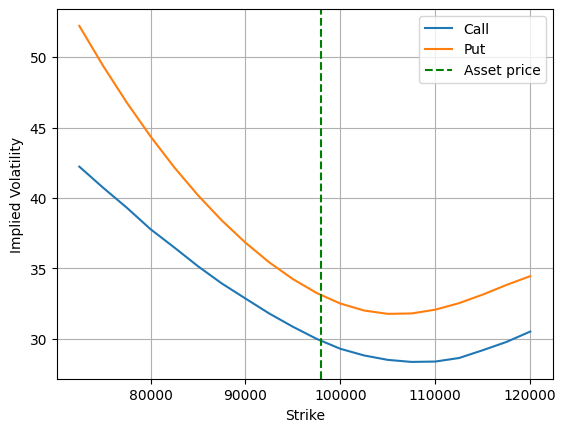

In [ ]:
import QuantLib as ql
import pandas as pd
import matplotlib.pyplot as plt


# Загрузка данных из таблицы
strike = [72500, 75000, 77500, 80000, 82500, 85000, 87500, 90000, 92500, 95000, 
          97500, 100000, 102500, 105000, 107500, 110000, 112500, 115000, 117500, 120000]
put_prices = [606, 702, 827, 991, 1206, 1489, 1860, 2343, 2964, 3753, 
              4737, 5940, 7374, 9033, 10898, 12935, 15107, 17379, 19722, 22113]
call_prices = [26350, 23950, 21580, 19240, 16960, 14740, 12610, 10600, 8720, 7010, 
               5490, 4190, 3130, 2290, 1650, 1180, 850, 630, 470, 360]
#strike, put_prices, call_prices = df[['Страйк', 'Теор. цена PUT', 'Теор. цена CALL']]

# Определение общих параметров для модели Black-Scholes-Merton
today = ql.Date.todaysDate()
ql.Settings.instance().evaluationDate = today
spot_price = 98000
risk_free_rate = 0.05
dividend_rate = 0.0
expiration_date = ql.Date(15, 6, 2023)
option_type = ql.Option.Call
sigma = 0.2

# Создание объекта модели
calculation_date = today
day_count = ql.Actual365Fixed()
calendar = ql.Russia()
volatilities_call = []
volatilities_put = []
volatilities = []
for i in range(len(strike)):
    strike_price = strike[i]
    put_price = put_prices[i]
    call_price = call_prices[i]

    # Определение опциона Call
    payoff = ql.PlainVanillaPayoff(option.Call, strike_price)
    exercise = ql.AmericanExercise(calculation_date, expiration_date)
    option = ql.VanillaOption(payoff, exercise)

    # Создание объекта модели
    spot_handle = ql.QuoteHandle(ql.SimpleQuote(spot_price))
    flat_ts = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)), day_count))
    dividend_yield = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                ql.QuoteHandle(ql.SimpleQuote(dividend_rate)), day_count))
    flat_vol_ts = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, 
                calendar, 0.2, day_count))
    bsm_process = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts, flat_vol_ts)

    # Рассчитываем подразумеваемую волатильность
    implied_vol_call = option.impliedVolatility(call_price, bsm_process)
    volatilities.append(implied_vol_call)

    # Определение опциона Put
    payoff_p = ql.PlainVanillaPayoff(option.Put, strike_price)
    exercise_p = ql.AmericanExercise(calculation_date, expiration_date)
    option = ql.VanillaOption(payoff_p, exercise_p)

    # Создание объекта модели
    spot_handle_p = ql.QuoteHandle(ql.SimpleQuote(spot_price))
    flat_ts_p = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                ql.QuoteHandle(ql.SimpleQuote(risk_free_rate)), day_count))
    dividend_yield_p = ql.YieldTermStructureHandle(ql.FlatForward(calculation_date, 
                ql.QuoteHandle(ql.SimpleQuote(dividend_rate)), day_count))
    flat_vol_ts_p = ql.BlackVolTermStructureHandle(ql.BlackConstantVol(calculation_date, 
                calendar, 0.2, day_count))
    bsm_process_p = ql.BlackScholesMertonProcess(spot_handle, dividend_yield, flat_ts_p, flat_vol_ts_p)

    # Рассчитываем подразумеваемую волатильность
    implied_vol_put = option.impliedVolatility(put_price, bsm_process_p)
    volatilities.append(implied_vol_put)
    # Appending implied volatilities for call and put options to their respective lists
    volatilities_call.append(implied_vol_call)
    volatilities_put.append(implied_vol_put)


    print(strike_price, round(implied_vol_call*100,2), round(implied_vol_put*100,2))

# Строим график подразумеваемой волатильности
# Modifying plot function to use the correct list of implied volatilities
plt.plot(strike, [vol*100 for vol in volatilities_call], label='Call') 
plt.plot(strike, [vol*100 for vol in volatilities_put], label='Put') 
plt.axvline(x=spot_price, linestyle='--', color='g', label='Asset price')
plt.xlabel('Strike') 
plt.ylabel('Implied Volatility') 
plt.grid(True)
plt.legend() 
plt.show()


60000
140000
Значение x_values, соответствующее ysum_values, близкое к 0:  98000


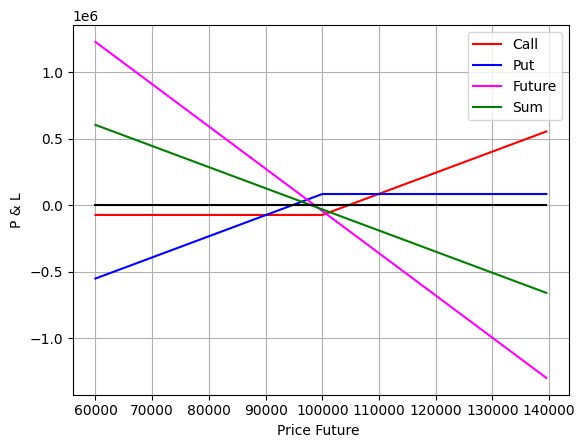

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pr_begin= 60000
pr_end= 140000
print(pr_begin)
print(pr_end)

st = 100000 #"Strike Call Option:"
price_call = 4580 #int(input("Price Call Option:"))
direct= 10 #int(input('Call Buy/Sell(+/-):'))
st_p= 100000 #int(input('Strike Put Option:'))
p_put= 5330 #int(input('Price Put Option:'))
direct_put= -10 #int(input('Put Buy/Sell(+/-):'))
dir_f= -20 # input Futures Positions
price_step=1.589
p_fut_pos=98650 # input Futures Price

def call(x, st, p_call, direct):
  if x < st :
    pnl=-price_call*direct
  else:
    pnl=(-price_call+(x-st))*direct
  return pnl

def put(x, st_p, p_put,direct_put):
  if x > st_p :
    pnl_p=-p_put*direct_put
  else:
    pnl_p=(-p_put+(st_p-x))*direct_put
  return pnl_p

x_values = []
y_values = []
y1_values = []
yf_values = []
ysum_values = []

for x in range( pr_begin, pr_end, 500):
  y=call(x, st, price_call, direct)*price_step
  x_values.append(x)
  y_values.append(y)
  y1=put(x, st_p, p_put, direct_put)*price_step
  y1_values.append(y1)
  yf=(x-p_fut_pos)*dir_f*price_step
  yf_values.append(yf)
  ysum_values.append(y+y1+yf)

df = pd.DataFrame({'X': x_values, 'Y' : ysum_values})
# Индекс элемента с наименьшим абсолютным значением
idxmin = df['Y'].abs().idxmin()

# Значение x_values соответствующее этому индексу
x_val = df.loc[idxmin, 'X']

print("Значение x_values, соответствующее ysum_values, близкое к 0: ", x_val)


plt.plot(x_values, y_values, color='red', label='Call')
plt.plot(x_values, y1_values, color='blue', label='Put')
plt.plot(x_values, yf_values, color='magenta', label='Future')
plt.plot(x_values, ysum_values, color='green', label='Sum')
plt.plot(x_values, [1]*len(x_values), color='black')
plt.xlabel('Price Future ')
plt.ylabel('P & L')
plt.grid()
plt.legend()
plt.show()